# Save an Embedding

Start with Embed 28.
Go back to K=4 without spaced seed.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
from tensorflow import keras
from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import Sequential
from keras.layers import Bidirectional
from keras.layers import GRU
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LayerNormalization

dt='float32'
tf.keras.backend.set_floatx(dt)

EPOCHS=50
SPLITS=2
K=4
VOCABULARY_SIZE=4**K+1   # e.g. K=3 => 64 DNA K-mers + 'NNN'
EMBED_DIMEN=16


## Load and partition sequences

In [2]:
# Assume file was preprocessed to contain one line per seq.
# Prefer Pandas dataframe but df does not support append.
# For conversion to tensor, must avoid python lists.
def load_fasta(filename,label):
    DEFLINE='>'
    labels=[]
    seqs=[]
    lens=[]
    nums=[]
    num=0
    with open (filename,'r') as infile:
        for line in infile:
            if line[0]!=DEFLINE:
                seq=line.rstrip()
                num += 1   # first seqnum is 1
                seqlen=len(seq)
                nums.append(num)
                labels.append(label)
                seqs.append(seq)
                lens.append(seqlen)
    df1=pd.DataFrame(nums,columns=['seqnum'])
    df2=pd.DataFrame(labels,columns=['class'])
    df3=pd.DataFrame(seqs,columns=['sequence'])
    df4=pd.DataFrame(lens,columns=['seqlen'])
    df=pd.concat((df1,df2,df3,df4),axis=1)
    return df

# Split into train/test stratified by sequence length.
def sizebin(df):
    return pd.cut(df["seqlen"],
                              bins=[0,1000,2000,4000,8000,16000,np.inf],
                              labels=[0,1,2,3,4,5])
def make_train_test(data):
    bin_labels= sizebin(data)
    from sklearn.model_selection import StratifiedShuffleSplit
    splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=37863)
    # split(x,y) expects that y is the labels. 
    # Trick: Instead of y, give it it the bin labels that we generated.
    for train_index,test_index in splitter.split(data,bin_labels):
        train_set = data.iloc[train_index]
        test_set = data.iloc[test_index]
    return (train_set,test_set)

def separate_X_and_y(data):
    y=   data[['class']].copy()
    X=   data.drop(columns=['class','seqnum','seqlen'])
    return (X,y)

def make_slice(data_set,min_len,max_len):
    print("original "+str(data_set.shape))
    too_short = data_set[ data_set['seqlen'] < min_len ].index
    no_short=data_set.drop(too_short)
    print("no short "+str(no_short.shape))
    too_long = no_short[ no_short['seqlen'] >= max_len ].index
    no_long_no_short=no_short.drop(too_long)
    print("no long, no short "+str(no_long_no_short.shape))
    return no_long_no_short


## Make K-mers

In [3]:
def make_kmer_table(K):
    npad='N'*K
    shorter_kmers=['']
    for i in range(K):
        longer_kmers=[]
        for mer in shorter_kmers:
            longer_kmers.append(mer+'A')
            longer_kmers.append(mer+'C')
            longer_kmers.append(mer+'G')
            longer_kmers.append(mer+'T')
        shorter_kmers = longer_kmers
    all_kmers = shorter_kmers
    kmer_dict = {}
    kmer_dict[npad]=0
    value=1
    for mer in all_kmers:
        kmer_dict[mer]=value
        value += 1
    return kmer_dict

KMER_TABLE=make_kmer_table(K)

def strings_to_vectors(data,uniform_len):
    all_seqs=[]
    for seq in data['sequence']:
        i=0
        seqlen=len(seq)
        kmers=[]
        while i < seqlen-K+1 -1:  # stop at minus one for spaced seed
            # kmer=seq[i:i+2]+seq[i+3:i+5]  spaced seed 2/1/2 for K=4
            kmer=seq[i:i+K]
            i += 1
            value=KMER_TABLE[kmer]
            kmers.append(value)
        pad_val=0
        while i < uniform_len:
            kmers.append(pad_val)
            i += 1
        all_seqs.append(kmers)
    pd2d=pd.DataFrame(all_seqs)
    return pd2d   # return 2D dataframe, uniform dimensions

In [4]:
def make_kmers(MAXLEN,train_set):
    (X_train_all,y_train_all)=separate_X_and_y(train_set)

    # The returned values are Pandas dataframes.
    # print(X_train_all.shape,y_train_all.shape)
    # (X_train_all,y_train_all)
    # y: Pandas dataframe to Python list.
    # y_train_all=y_train_all.values.tolist()
    # The sequences lengths are bounded but not uniform.
    X_train_all
    print(type(X_train_all))
    print(X_train_all.shape)
    print(X_train_all.iloc[0])
    print(len(X_train_all.iloc[0]['sequence']))

    # X: List of string to List of uniform-length ordered lists of K-mers.
    X_train_kmers=strings_to_vectors(X_train_all,MAXLEN)
    # X: true 2D array (no more lists)
    X_train_kmers.shape

    print("transform...")
    # From pandas dataframe to numpy to list to numpy
    print(type(X_train_kmers))
    num_seqs=len(X_train_kmers)
    tmp_seqs=[]
    for i in range(num_seqs):
        kmer_sequence=X_train_kmers.iloc[i]
        tmp_seqs.append(kmer_sequence)
    X_train_kmers=np.array(tmp_seqs)
    tmp_seqs=None
    print(type(X_train_kmers))
    print(X_train_kmers)

    labels=y_train_all.to_numpy()
    return (X_train_kmers,labels)

In [5]:
def make_frequencies(Xin):
    # Input:  numpy X(numseq,seqlen)  list of vectors of kmerval where val0=NNN,val1=AAA,etc. 
    # Output: numpy X(numseq,65)    list of frequencies of 0,1,etc.
    Xout=[]
    VOCABULARY_SIZE= 4**K + 1  # plus one for 'NNN'
    for seq in Xin:
        freqs =[0] * VOCABULARY_SIZE
        total = 0
        for kmerval in seq:
            freqs[kmerval] += 1
            total += 1
        for c in range(VOCABULARY_SIZE):
            freqs[c] = freqs[c]/total
        Xout.append(freqs)
    Xnum = np.asarray(Xout)
    return (Xnum)

## Build model

In [6]:
def build_model(maxlen,dimen):
    act="sigmoid"

    rnn = keras.models.Sequential()
    embed_layer = keras.layers.Embedding(
        VOCABULARY_SIZE,EMBED_DIMEN,input_length=maxlen);
    flat_layer = keras.layers.Flatten()
    rnn1_layer = keras.layers.GRU(16,activation=act,
                                  dropout=0.50,
                                return_sequences=True)
    rnn2_layer = keras.layers.GRU(16,activation=act,dropout=0.50,)
    output_layer = keras.layers.Dense(1,activation=act,dtype=dt)

    rnn.add(embed_layer)
    rnn.add(rnn1_layer)
    rnn.add(rnn2_layer)
    rnn.add(output_layer)
    
    bc=tf.keras.losses.BinaryCrossentropy(from_logits=False)
    print("COMPILE...")
    opt = keras.optimizers.Adam(learning_rate=0.01) #default 0.001
    rnn.compile(loss=bc, optimizer=opt, metrics=["accuracy"])
    print("...COMPILED")
    return (rnn)

## Cross validation

In [7]:
def do_cross_validation(X,y,eps,maxlen,dimen):
    cv_scores = []
    fold=0
    splitter = ShuffleSplit(n_splits=SPLITS, test_size=0.2, random_state=37863)
    rnn = None
    for train_index,valid_index in splitter.split(X):
        X_train=X[train_index] # use iloc[] for dataframe
        y_train=y[train_index]
        X_valid=X[valid_index]
        y_valid=y[valid_index]

        print("BUILD MODEL")
        rnn=build_model(maxlen,dimen)

        print("FIT")
        # this is complaining about string to float
        history=rnn.fit(X_train, y_train, # batch_size=10, default=32 works nicely
                epochs=eps, verbose=1,  # verbose=1 for ascii art, verbose=0 for none
                validation_data=(X_valid,y_valid) )
                        
        fold += 1
        print("Fold %d, %d epochs"%(fold,eps))

        pd.DataFrame(history.history).plot(figsize=(8,5))
        plt.grid(True)
        plt.gca().set_ylim(0,1)
        plt.show()

        scores = rnn.evaluate(X_valid, y_valid, verbose=0)
        print("%s: %.2f%%" % (rnn.metrics_names[1], scores[1]*100))
        # What are the other metrics_names?
        # Try this from Geron page 505:
        # np.mean(keras.losses.mean_squared_error(y_valid,y_pred))
        cv_scores.append(scores[1] * 100)
    print()
    print("Validation core mean %.2f%% (+/- %.2f%%)" % (np.mean(cv_scores), np.std(cv_scores)))
    return rnn

## Load

In [8]:
print("Load data from files.")
nc_seq=load_fasta('ncRNA.fasta',0)
pc_seq=load_fasta('pcRNA.fasta',1)
all_seq=pd.concat((nc_seq,pc_seq),axis=0)

print("Put aside the test portion.")
(train_set,test_set)=make_train_test(all_seq)
# Do this later when using the test data:
# (X_test,y_test)=separate_X_and_y(test_set)

nc_seq=None
pc_seq=None
all_seq=None

print("Ready: train_set")
train_set

Load data from files.
Put aside the test portion.
Ready: train_set


,seqnum,class,sequence,seqlen
1280,1281,0,AGTCCCTCCCCAGCCCAGCAGTCCCTCCAGGCTACATCCAGGAGAC...,348
9088,9089,0,CAGCTCCTGGGATGGCCTCACCTGAGGAGACTCTTGGGCCTTGGCA...,534
6069,6070,1,AGATCTAGGGATGGGGATGGGGAGGAGAAGTGGGAATGGGAAATTG...,592
18549,18550,1,GACGTCTCCCGCGGGCGTCGGCAGGGTCGGCGGCGTCGGCAGCAGT...,945
15027,15028,1,GAGCGCGCGAGCCGGGCCCGGAGCGCACGCCGCCGCCGCCACCGCC...,4382
...,...,...,...,...
3386,3387,0,TTTATGTGGATTGTCTGTCTCATGCTTGTTTCACCAGGGTAGTTAC...,578
6495,6496,0,ATAATGGGAAACTAAGGGCAAGTTCTCATGTTCCTGGTCCTGGCTT...,562
6409,6410,1,GGGTTTATTACTACTGAAGGAAGAACGTGAGTAGGTTAGGATTTCG...,740
7640,7641,1,ACAGCTGTGTTTGGCTGCAGGGCCAAGAGCGCTGTCAAGAAGACCC...,3156


## Slice: small

Compile the model
COMPILE...
...COMPILED
Summarize the model
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1000, 16)          4112      
_________________________________________________________________
gru (GRU)                    (None, 1000, 16)          1632      
_________________________________________________________________
gru_1 (GRU)                  (None, 16)                1632      
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 7,393
Trainable params: 7,393
Non-trainable params: 0
_________________________________________________________________
None
Working on full training set, slice by sequence length.
Slice size range [200 - 1000)
original (30290, 4)
no short (30290, 4)
no long, no short (8879, 4)
Sequence to Kmer
<class 'pandas.

Epoch 47/50
222/222 [==============================] - 263s 1s/step - loss: 0.3434 - accuracy: 0.8436 - val_loss: 0.5080 - val_accuracy: 0.7596
Epoch 48/50
222/222 [==============================] - 256s 1s/step - loss: 0.3385 - accuracy: 0.8560 - val_loss: 0.5094 - val_accuracy: 0.7607
Epoch 49/50
222/222 [==============================] - 272s 1s/step - loss: 0.3385 - accuracy: 0.8491 - val_loss: 0.5153 - val_accuracy: 0.7584
Epoch 50/50
222/222 [==============================] - 269s 1s/step - loss: 0.3357 - accuracy: 0.8516 - val_loss: 0.4473 - val_accuracy: 0.7950
Fold 1, 50 epochs


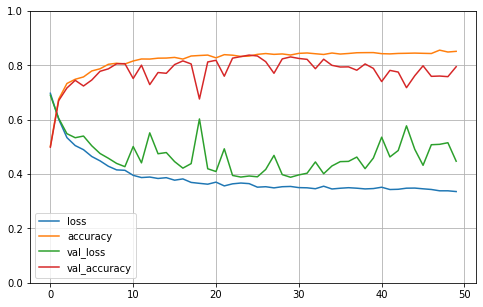

accuracy: 79.50%
BUILD MODEL
COMPILE...
...COMPILED
FIT
Epoch 1/50
222/222 [==============================] - 280s 1s/step - loss: 0.6957 - accuracy: 0.5108 - val_loss: 0.6935 - val_accuracy: 0.5045
Epoch 2/50
222/222 [==============================] - 279s 1s/step - loss: 0.6594 - accuracy: 0.5941 - val_loss: 0.6137 - val_accuracy: 0.6757
Epoch 3/50
222/222 [==============================] - 263s 1s/step - loss: 0.5542 - accuracy: 0.7184 - val_loss: 0.5634 - val_accuracy: 0.7083
Epoch 4/50
222/222 [==============================] - 264s 1s/step - loss: 0.4947 - accuracy: 0.7601 - val_loss: 0.9354 - val_accuracy: 0.5343
Epoch 5/50
222/222 [==============================] - 266s 1s/step - loss: 0.4478 - accuracy: 0.7922 - val_loss: 0.9512 - val_accuracy: 0.5394
Epoch 6/50
222/222 [==============================] - 270s 1s/step - loss: 0.4246 - accuracy: 0.8077 - val_loss: 0.9286 - val_accuracy: 0.5405
Epoch 7/50
222/222 [==============================] - 294s 1s/step - loss: 0.4117 - ac

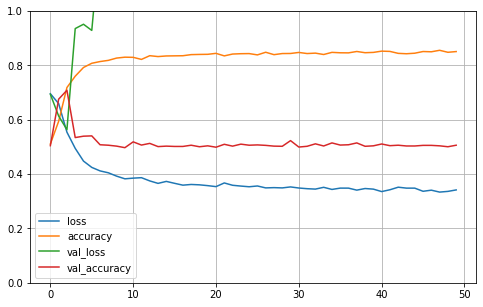

accuracy: 50.62%

Validation core mean 65.06% (+/- 14.44%)
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: Embed_29.small.model/assets


In [9]:
MINLEN=200
MAXLEN=1000

print ("Compile the model")
model=build_model(MAXLEN,EMBED_DIMEN)
print ("Summarize the model")
print(model.summary())  # Print this only once

print("Working on full training set, slice by sequence length.")
print("Slice size range [%d - %d)"%(MINLEN,MAXLEN))
subset=make_slice(train_set,MINLEN,MAXLEN)# One array to two: X and y

print ("Sequence to Kmer")
(X_train,y_train)=make_kmers(MAXLEN,subset)
X_train
print ("Cross valiation")
model = do_cross_validation(X_train,y_train,EPOCHS,MAXLEN,EMBED_DIMEN)
MODEL_FILENAME="Embed_29.small.model"
model.save(MODEL_FILENAME)

## Slice: medium

Compile the model
COMPILE...
...COMPILED
Summarize the model
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 2000, 16)          4112      
_________________________________________________________________
gru_6 (GRU)                  (None, 2000, 16)          1632      
_________________________________________________________________
gru_7 (GRU)                  (None, 16)                1632      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 7,393
Trainable params: 7,393
Non-trainable params: 0
_________________________________________________________________
None
Working on full training set, slice by sequence length.
Slice size range [1000 - 2000)
original (30290, 4)
no short (9273, 4)
no long, no short (3368, 4)
Sequence to Kmer
<class 'panda

85/85 [==============================] - 196s 2s/step - loss: 0.5665 - accuracy: 0.6919 - val_loss: 0.6419 - val_accuracy: 0.6691
Epoch 48/50
85/85 [==============================] - 195s 2s/step - loss: 0.5538 - accuracy: 0.7008 - val_loss: 0.6273 - val_accuracy: 0.6795
Epoch 49/50
85/85 [==============================] - 196s 2s/step - loss: 0.5575 - accuracy: 0.7105 - val_loss: 0.6291 - val_accuracy: 0.6855
Epoch 50/50
85/85 [==============================] - 196s 2s/step - loss: 0.5457 - accuracy: 0.7223 - val_loss: 0.6507 - val_accuracy: 0.6899
Fold 1, 50 epochs


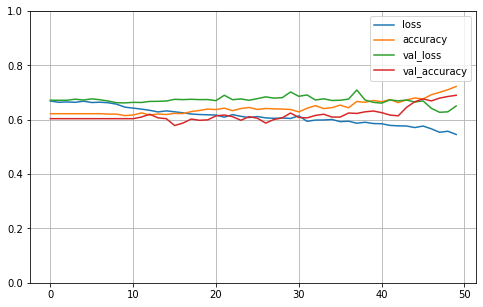

accuracy: 68.99%
BUILD MODEL
COMPILE...
...COMPILED
FIT
Epoch 1/50
85/85 [==============================] - 213s 3s/step - loss: 0.6695 - accuracy: 0.6121 - val_loss: 0.6634 - val_accuracy: 0.6261
Epoch 2/50
85/85 [==============================] - 209s 2s/step - loss: 0.6704 - accuracy: 0.6166 - val_loss: 0.6610 - val_accuracy: 0.6261
Epoch 3/50
85/85 [==============================] - 206s 2s/step - loss: 0.6674 - accuracy: 0.6166 - val_loss: 0.6617 - val_accuracy: 0.6261
Epoch 4/50
85/85 [==============================] - 206s 2s/step - loss: 0.6698 - accuracy: 0.6166 - val_loss: 0.6613 - val_accuracy: 0.6261
Epoch 5/50
85/85 [==============================] - 206s 2s/step - loss: 0.6672 - accuracy: 0.6166 - val_loss: 0.6620 - val_accuracy: 0.6261
Epoch 6/50
85/85 [==============================] - 205s 2s/step - loss: 0.6672 - accuracy: 0.6166 - val_loss: 0.6646 - val_accuracy: 0.6261
Epoch 7/50
85/85 [==============================] - 188s 2s/step - loss: 0.6696 - accuracy: 0.6166

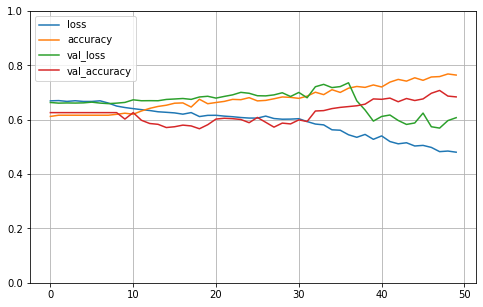

accuracy: 68.40%

Validation core mean 68.69% (+/- 0.30%)
INFO:tensorflow:Assets written to: Embed_29.medium.model/assets


In [10]:
MINLEN=1000
MAXLEN=2000

print ("Compile the model")
model=build_model(MAXLEN,EMBED_DIMEN)
print ("Summarize the model")
print(model.summary())  # Print this only once

print("Working on full training set, slice by sequence length.")
print("Slice size range [%d - %d)"%(MINLEN,MAXLEN))
subset=make_slice(train_set,MINLEN,MAXLEN)# One array to two: X and y

print ("Sequence to Kmer")
(X_train,y_train)=make_kmers(MAXLEN,subset)
X_train
print ("Cross valiation")
model = do_cross_validation(X_train,y_train,EPOCHS,MAXLEN,EMBED_DIMEN)
MODEL_FILENAME="Embed_29.medium.model"
model.save(MODEL_FILENAME)

## Slice: large

Compile the model
COMPILE...
...COMPILED
Summarize the model
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 3000, 16)          4112      
_________________________________________________________________
gru_12 (GRU)                 (None, 3000, 16)          1632      
_________________________________________________________________
gru_13 (GRU)                 (None, 16)                1632      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 17        
Total params: 7,393
Trainable params: 7,393
Non-trainable params: 0
_________________________________________________________________
None
Working on full training set, slice by sequence length.
Slice size range [2000 - 3000)
original (30290, 4)
no short (3221, 4)
no long, no short (1351, 4)
Sequence to Kmer
<class 'panda

34/34 [==============================] - 124s 4s/step - loss: 0.5352 - accuracy: 0.7352 - val_loss: 0.6653 - val_accuracy: 0.6568
Epoch 48/50
34/34 [==============================] - 123s 4s/step - loss: 0.5190 - accuracy: 0.7583 - val_loss: 0.6642 - val_accuracy: 0.6531
Epoch 49/50
34/34 [==============================] - 123s 4s/step - loss: 0.5154 - accuracy: 0.7639 - val_loss: 0.6452 - val_accuracy: 0.6716
Epoch 50/50
34/34 [==============================] - 124s 4s/step - loss: 0.5173 - accuracy: 0.7602 - val_loss: 0.6429 - val_accuracy: 0.6753
Fold 1, 50 epochs


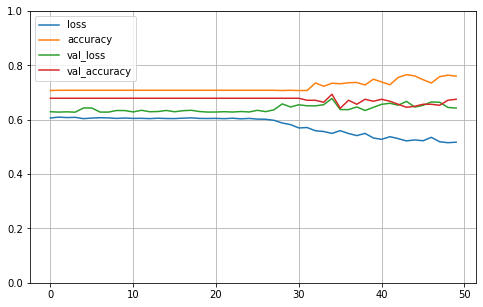

accuracy: 67.53%
BUILD MODEL
COMPILE...
...COMPILED
FIT
Epoch 1/50
34/34 [==============================] - 129s 4s/step - loss: 0.6285 - accuracy: 0.6861 - val_loss: 0.6003 - val_accuracy: 0.7122
Epoch 2/50
34/34 [==============================] - 128s 4s/step - loss: 0.6127 - accuracy: 0.7000 - val_loss: 0.6007 - val_accuracy: 0.7122
Epoch 3/50
34/34 [==============================] - 129s 4s/step - loss: 0.6120 - accuracy: 0.7000 - val_loss: 0.6031 - val_accuracy: 0.7122
Epoch 4/50
34/34 [==============================] - 129s 4s/step - loss: 0.6115 - accuracy: 0.7000 - val_loss: 0.6004 - val_accuracy: 0.7122
Epoch 5/50
34/34 [==============================] - 129s 4s/step - loss: 0.6135 - accuracy: 0.7000 - val_loss: 0.6004 - val_accuracy: 0.7122
Epoch 6/50
34/34 [==============================] - 129s 4s/step - loss: 0.6121 - accuracy: 0.7000 - val_loss: 0.6056 - val_accuracy: 0.7122
Epoch 7/50
34/34 [==============================] - 129s 4s/step - loss: 0.6119 - accuracy: 0.7000

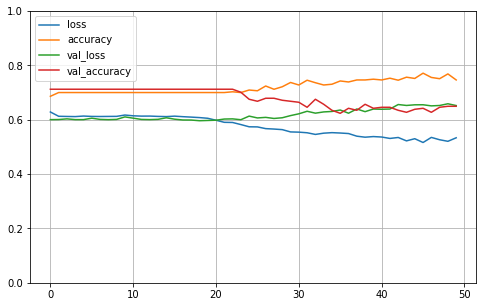

accuracy: 64.94%

Validation core mean 66.24% (+/- 1.29%)
INFO:tensorflow:Assets written to: Embed_29.large.model/assets


In [11]:
MINLEN=2000
MAXLEN=3000

print ("Compile the model")
model=build_model(MAXLEN,EMBED_DIMEN)
print ("Summarize the model")
print(model.summary())  # Print this only once

print("Working on full training set, slice by sequence length.")
print("Slice size range [%d - %d)"%(MINLEN,MAXLEN))
subset=make_slice(train_set,MINLEN,MAXLEN)# One array to two: X and y

print ("Sequence to Kmer")
(X_train,y_train)=make_kmers(MAXLEN,subset)
X_train
print ("Cross valiation")
model = do_cross_validation(X_train,y_train,EPOCHS,MAXLEN,EMBED_DIMEN)
MODEL_FILENAME="Embed_29.large.model"
model.save(MODEL_FILENAME)